In [24]:
# Copyright 2016 Hui Ma. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Builds the Chart Analysis Convolutional Neural Network.

Summary of available functions:

 # Compute input images and labels for training and testing.

 # Build and train a network to make a prediction.
"""
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Convolution2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout
import sys
import chart_analyst_input as ca_input
from datetime import datetime


import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
np.random.seed(123)
# Define default chart size
x_pix_num_default = 256
y_pix_num_default = 256

# By default each chart has 128 bars. It is about half year for daily bars.
# Training set has 128 charts.
def compute_train_set(last_id, train_set_size=128, train_img_size=128, x_pix_num = x_pix_num_default, y_pix_num = y_pix_num_default, forward_bar_num=5):
    train_imgs = np.zeros((train_set_size, 1, y_pix_num, x_pix_num))  # `(samples, channels, rows, cols)` if dim_ordering='th'已改tf
    train_labels = np.zeros(train_set_size)
    for i in range(last_id, last_id - train_set_size, -1):
        ca_input.ca_draw_line_chart(csv_data, i, train_imgs[last_id-i][0], x_pix_num=x_pix_num, y_pix_num=y_pix_num, line_width = 1)
        # Use the commented code to check chart and its label
        ca_input.cr_plot_image(train_imgs[last_id-i][0])
        train_labels[last_id - i] = ca_input.ca_decide_chart_label(csv_data, i, train_img_size, forward_bar_num)
        #print train_labels[last_id-i]
    train_imgs = np.transpose(train_imgs,[0,2,3,1]) #为了tf改形状
    print_label_percentage(train_labels)
    return (train_imgs, train_labels)

# By default to test 1 week = 5 days for each training model
def compute_test_set(first_id, test_set_size=5, test_img_size=128, x_pix_num = x_pix_num_default, y_pix_num = y_pix_num_default, forward_bar_num=5):
    test_imgs = np.zeros((test_set_size, 1,  y_pix_num, x_pix_num))  # `(samples, channels, rows, cols)` if dim_ordering='th'
    test_labels = np.zeros(test_set_size)
    for i in range(first_id, first_id + test_set_size):
        ca_input.ca_draw_line_chart(csv_data, i, test_imgs[first_id - i][0], x_pix_num=x_pix_num, y_pix_num=y_pix_num, line_width=1)
        # Use the commented code to check chart and its label
        #ca_input.cr_plot_image(img)
        test_labels[first_id - i] = ca_input.ca_decide_chart_label(csv_data, i, test_img_size, forward_bar_num)
        #print test_labels[first_id - i]
    test_imgs = np.transpose(test_imgs,[0,2,3,1]) #为了tf改形状
    return (test_imgs, test_labels)

# for each round, build and train a clean model
def predict(train_imgs, train_labels, test_imgs, test_labels, x_pix_num=x_pix_num_default, y_pix_num=y_pix_num_default,
            use_saved_weights=False, weights_file_name=''):

    model = Sequential()
    # use partial VGG16 model
    model.add(ZeroPadding2D((1, 1), input_shape=(y_pix_num, x_pix_num,1)))
    
    base_filter_num = 64
    model.add(Convolution2D(base_filter_num, 3, 3, activation='relu', name='conv1_1'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))  # added this layer to reduce the input size
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(base_filter_num, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(base_filter_num * 2, 3, 3, activation='relu', name='conv2_1'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(base_filter_num *2, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, init='uniform', activation='tanh'))
    model.add(Dropout(0.25))
    model.add(Dense(64, init='uniform', activation='tanh'))
    model.add(Dense(3, init='uniform', activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    if use_saved_weights:
        model.load_weights(weights_file_name)  #need to install h5py
    else:
        start_time = datetime.today()
        checkpointer = ModelCheckpoint(filepath=weights_file_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='max')
        model.fit(train_imgs, train_labels,
                        nb_epoch=30,
                        verbose=1,
                        batch_size=70,
                        validation_split=0.1,
                        callbacks=[checkpointer, earlyStopping])
        model.load_weights(weights_file_name)
        end_time = datetime.today()
        print "----trained time is from " + str(start_time) + " to " + str(end_time)
        
    predict_rst = model.predict_proba(test_imgs, verbose=0)
    return predict_rst

def is_Friday(str_date):
    obj_date = datetime.strptime(str_date, '%Y-%m-%d')
    return (obj_date.isoweekday() == 5);

def print_rst(rst):
    for i in range(0, 3):
        for j in range(0, 3):
            sys.stdout.write(str(rst[i][j]) + "  ")
        print " "
    print '\n'

def print_label_percentage(train_labels):
    sum_0 = 0.
    sum_1 = 0.
    sum_2 = 0.
    for i in range(0, len(train_labels)):
        if train_labels[i] == 0:
            sum_0 += 1
        elif train_labels[i] == 1:
            sum_1 += 1
        else:
            sum_2 += 1
    sum_all = len(train_labels)
    print "0:" + str(sum_0/sum_all) + " 1:" + str(sum_1/sum_all) + " 2:" + str(sum_2/sum_all)

In [8]:
if __name__ == "__main__":
#    csv_data = ca_input.read_csv_file('./spy.csv')
    csv_data = pd.read_csv('./spy.csv', delimiter=',')
    data_num, col_num = np.shape(csv_data)
    # The train_set_size is 128. And for each train image, there are train_img_size (128) records.
    # Also add 5 more record to decide label.
    # Total is 128 + 128 + 5 = 261, start from 270
    train_set_size = 128
    train_img_size = 128  # half year
    test_set_size = 6 # Friday + 1 week, the first test id is the trained id, it cannot be used for real trade
    test_img_size = train_img_size
    forward_bar_num = 5  # Set label based on price change in forward_bar_num
    rst = np.zeros((3,3))
    for i in range(270, data_num):
        if not is_Friday(csv_data['Date'][i]):
            continue
        print "train on " + str(csv_data['Date'][i])
        train_imgs, train_labels = compute_train_set(i - forward_bar_num, train_set_size, train_img_size, forward_bar_num=forward_bar_num)
        test_imgs, test_labels = compute_test_set(i, test_set_size, test_img_size, forward_bar_num=forward_bar_num)
        
        predict_rst = predict(train_imgs, train_labels, test_imgs, test_labels, weights_file_name='./weight/weights_'+str(csv_data['Date'][i])+'.txt')
        for j in range(0, test_set_size):
            predicted_index = np.argmax(predict_rst[j])
            print "----predicted on " + str(csv_data['Date'][i+j]) + " real:" + str(int(test_labels[j])) + " predict:" + str(predicted_index) + " " + str(predict_rst[j])
            if j != 0:
                rst[predicted_index][int(test_labels[j])] += 1
        print_rst(rst)

train on 1994-02-25
0:0.328125 1:0.234375 2:0.4375
Train on 115 samples, validate on 13 samples
Epoch 1/30
115/115 [==============================] - 23s - loss: 1.0985 - acc: 0.4000 - val_loss: 1.0982 - val_acc: 0.4615
Epoch 2/30
115/115 [==============================] - 22s - loss: 1.0979 - acc: 0.4348 - val_loss: 1.0977 - val_acc: 0.4615
Epoch 3/30


KeyboardInterrupt: 

In [20]:
    csv_data = pd.read_csv('./spy.csv', delimiter=',')
    data_num, col_num = np.shape(csv_data)
    # The train_set_size is 128. And for each train image, there are train_img_size (128) records.
    # Also add 5 more record to decide label.
    # Total is 128 + 128 + 5 = 261, start from 270
    train_set_size = 128
    train_img_size = 128  # half year
    test_set_size = 6 # Friday + 1 week, the first test id is the trained id, it cannot be used for real trade
    test_img_size = train_img_size
    forward_bar_num = 5  # Set label based on price change in forward_bar_num
    rst = np.zeros((3,3))

0:0.375 1:0.1796875 2:0.4453125


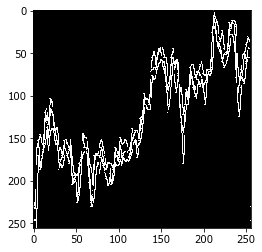

In [26]:
train_imgs, train_labels = compute_train_set(333 - forward_bar_num, train_set_size, train_img_size, forward_bar_num=forward_bar_num)
#test_imgs, test_labels = compute_test_set(333, test_set_size, test_img_size, forward_bar_num=forward_bar_num)

In [22]:
train_imgs.shape

(128, 256, 256, 1)

In [23]:
cc = train_imgs.reshape([128,256,256])

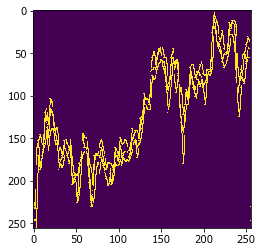

In [27]:
plt.imshow(cc[-1,:,:])